In [1]:
import torch.nn as nn
import torch
from learned_dict import TiedSAE
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from transformers import ViTForImageClassification, ViTFeatureExtractor
from util import ActivationDataset
import torchvision.transforms as transforms
from collections import Counter
import torch.nn.functional as F


/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-02-22 16:09:40.744591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 16:09:40.744817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 16:09:40.748361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 16:09:44.155017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = 'nateraw/vit-base-patch16-224-cifar10'
model = ViTForImageClassification.from_pretrained(vit_model, output_hidden_states=True).to(device)
model.eval()
feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model)
to_pil = transforms.ToPILImage()


/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Cifar x10

## No SAE, original transformer neurons

In [3]:
for num_features in [3,5,10,20]:
    for cls in range(10):
        activation=f'activations_cifar10_vit_b/cifar10_activations_{cls}.h5'
        dataset_layer10 = ActivationDataset(activation,'vit.encoder.layer.10.output')
        dataset_layer11 = ActivationDataset(activation,'vit.encoder.layer.11.output')

        combined_dataset = torch.utils.data.ConcatDataset([dataset_layer10, dataset_layer11])
        data_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)
        
        top_activations = []
        
        with torch.no_grad():
            for i, (images, activations) in enumerate(data_loader):
                activations = activations.to(device)
                top_indices = torch.topk(activations.mean(dim=1), k=num_features+3, largest=True).indices
                top_activations.append(top_indices)
        top_activations = torch.cat(top_activations, dim=0)

        value_counts = Counter(top_activations.cpu().numpy().flatten().tolist())
        indices_to_keep = [key for key, _ in value_counts.most_common(num_features)]
        indices_to_zero = [i for i in range(activations.shape[2]) if i not in indices_to_keep]

        with torch.no_grad():
            total = 0
            correct = 0
            for i, (images, activations) in enumerate(data_loader):
                activations = activations.to(device)
                activations[:,:,indices_to_zero] = 0
                preds = model.classifier(activations).mean(dim=1).argmax(dim=1)
                total += preds.shape[0]
                correct += preds.eq(cls).sum().item()
            
            print(value_counts.most_common(num_features))
            print(f'Accuracy: {correct/total}')
            print(correct, total)

[(187, 2000), (382, 1907), (695, 1078)]
Accuracy: 0.0275
55 2000
[(187, 2000), (382, 1671), (396, 1450)]
Accuracy: 0.0
0 2000
[(187, 2000), (382, 1782), (662, 825)]
Accuracy: 0.0
0 2000
[(187, 2000), (382, 1910), (26, 1230)]
Accuracy: 0.8035
1607 2000
[(187, 1999), (382, 1884), (84, 1541)]
Accuracy: 0.0
0 2000
[(187, 2000), (382, 1199), (445, 1079)]
Accuracy: 0.0005
1 2000
[(187, 2000), (92, 1909), (382, 1741)]
Accuracy: 0.009
18 2000
[(187, 2000), (382, 1940), (545, 1225)]
Accuracy: 0.0
0 2000
[(187, 2000), (382, 1962), (485, 1650)]
Accuracy: 1.0
2000 2000
[(187, 2000), (382, 1140), (172, 1002)]
Accuracy: 0.0
0 2000
[(187, 2000), (382, 1925), (695, 1394), (604, 943), (250, 918)]
Accuracy: 0.759
1518 2000
[(187, 2000), (382, 1705), (396, 1615), (735, 997), (250, 865)]
Accuracy: 0.0
0 2000
[(187, 2000), (382, 1809), (662, 970), (334, 817), (64, 657)]
Accuracy: 0.038
76 2000
[(187, 2000), (382, 1929), (26, 1473), (709, 727), (35, 705)]
Accuracy: 0.9875
1975 2000
[(187, 1999), (382, 1908)

## Using most activated features in last 2 layers as classifiers

In [13]:
def use_as_classifier(activation,vitmodel, SAEmodel, ratio, cls, num_features=3, finetuned_model=None):
    model = ViTForImageClassification.from_pretrained(vitmodel).to(device)
    
    if finetuned_model is not None:
        # load trained model weight
        if 'cifar' in SAEmodel:
            model.classifier = nn.Linear(model.config.hidden_size, 10) # initizliae classifier for loading finetuned weight
            #dino with ViTForImageClassification classifer has classifier with 2 outputs
        model.load_state_dict(torch.load(finetuned_model))
        
    model.to(device)
    model.eval()

    # Create a DataLoader
    dataset_layer10 = ActivationDataset(activation,'vit.encoder.layer.10.output')
    dataset_layer11 = ActivationDataset(activation,'vit.encoder.layer.11.output')

    combined_dataset = torch.utils.data.ConcatDataset([dataset_layer10, dataset_layer11])

    data_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)
    # load SAE
    activation_size = 768
    n_dict_components = ratio * activation_size

    encoder = torch.randn((n_dict_components, activation_size), device = device) # encoder
    nn.init.xavier_uniform_(encoder)
    encoder_bias = torch.zeros(n_dict_components, device = device) # encoder bias

    # Create a TiedSAE instance
    tied_sae = TiedSAE(encoder, encoder_bias)
    tied_sae.load_state_dict(torch.load(SAEmodel))
    tied_sae.to_device(device)

    tied_sae.encoder.requires_grad = False
    tied_sae.encoder_bias.requires_grad = False
    top_activations = []

    with torch.no_grad():
        for i, (images, activations) in enumerate(data_loader):
            activations = activations.to(device)
            c = tied_sae.encode(activations)
            top_indices = torch.topk(c.mean(dim=1), k=num_features+3, largest=True).indices
            top_activations.append(top_indices)
    top_activations = torch.cat(top_activations, dim=0)

    value_counts = Counter(top_activations.cpu().numpy().flatten().tolist())
    indices_to_keep = [key for key, _ in value_counts.most_common(num_features)]
    indices_to_zero = [i for i in range(c.shape[2]) if i not in indices_to_keep]

    with torch.no_grad():
        total = 0
        correct = 0
        for i, (images, activations) in enumerate(data_loader):
            activations = activations.to(device)
            c = tied_sae.encode(activations)
            c[:,:,indices_to_zero] = 0
            c_0 = tied_sae.decode(c)
            preds = model.classifier(c_0).mean(dim=1).argmax(dim=1)
            total += preds.shape[0]
            correct += preds.eq(cls).sum().item()
        
        print(value_counts.most_common(num_features))
        print(f'Accuracy: {correct/total}')
        print(correct, total)


In [13]:
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_vit_b/cifar10_activations_{i}.h5',vitmodel='nateraw/vit-base-patch16-224-cifar10',SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=1)

[(4775, 1988)]
Accuracy: 1.0
2000 2000
[(5266, 1998)]
Accuracy: 1.0
2000 2000
[(2792, 1990)]
Accuracy: 1.0
2000 2000
[(6775, 1982)]
Accuracy: 1.0
2000 2000
[(1189, 1996)]
Accuracy: 1.0
2000 2000
[(2525, 1996)]
Accuracy: 1.0
2000 2000
[(1454, 1996)]
Accuracy: 1.0
2000 2000
[(599, 1993)]
Accuracy: 1.0
2000 2000
[(319, 1996)]
Accuracy: 1.0
2000 2000
[(3673, 1993)]
Accuracy: 1.0
2000 2000


In [14]:
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_vit_b/cifar10_activations_{i}.h5',vitmodel='nateraw/vit-base-patch16-224-cifar10',SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=3)

[(4775, 1990), (5115, 1988), (7613, 1166)]
Accuracy: 1.0
2000 2000
[(5266, 1999), (509, 1995), (6348, 993)]
Accuracy: 1.0
2000 2000
[(2792, 1992), (578, 1814), (2117, 1020)]
Accuracy: 1.0
2000 2000
[(6775, 1985), (6998, 1809), (6348, 1105)]
Accuracy: 1.0
2000 2000
[(1189, 1996), (1740, 1981), (318, 995)]
Accuracy: 1.0
2000 2000
[(2525, 2000), (6941, 1952), (4655, 1138)]
Accuracy: 1.0
2000 2000
[(1454, 1998), (3974, 1997), (880, 1145)]
Accuracy: 1.0
2000 2000
[(599, 1994), (7100, 1984), (1141, 1902)]
Accuracy: 1.0
2000 2000
[(319, 1996), (2131, 1993), (7462, 991)]
Accuracy: 0.9995
1999 2000
[(3673, 1997), (6802, 1977), (2124, 980)]
Accuracy: 1.0
2000 2000


In [15]:
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_vit_b/cifar10_activations_{i}.h5',vitmodel='nateraw/vit-base-patch16-224-cifar10',SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=5)

[(4775, 1993), (5115, 1989), (880, 1391), (7613, 1292), (6348, 990)]
Accuracy: 1.0
2000 2000
[(5266, 1999), (509, 1996), (880, 1575), (6348, 999), (357, 996)]
Accuracy: 1.0
2000 2000
[(2792, 1994), (578, 1895), (880, 1239), (2117, 1049), (3967, 985)]
Accuracy: 1.0
2000 2000
[(6775, 1988), (6998, 1848), (880, 1437), (6348, 1234), (2525, 1153)]
Accuracy: 0.902
1804 2000
[(1189, 1996), (1740, 1987), (880, 1197), (6348, 1058), (318, 1045)]
Accuracy: 1.0
2000 2000
[(2525, 2000), (6941, 1963), (880, 1368), (4655, 1213), (6348, 1001)]
Accuracy: 1.0
2000 2000
[(1454, 1998), (3974, 1997), (880, 1679), (6535, 1133), (3156, 1048)]
Accuracy: 1.0
2000 2000
[(599, 1995), (7100, 1987), (1141, 1960), (6925, 1075), (6348, 991)]
Accuracy: 0.999
1998 2000
[(319, 1996), (2131, 1995), (880, 1574), (6884, 1044), (6348, 1000)]
Accuracy: 0.9995
1999 2000
[(3673, 1998), (6802, 1983), (5266, 1031), (6348, 998), (2124, 995)]
Accuracy: 0.9825
1965 2000


In [16]:
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_vit_b/cifar10_activations_{i}.h5',vitmodel='nateraw/vit-base-patch16-224-cifar10',SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=10)

[(4775, 1996), (5115, 1994), (880, 1930), (6535, 1813), (2684, 1537), (7613, 1425), (1298, 1316), (6348, 1040), (7454, 1018), (5703, 999)]
Accuracy: 1.0
2000 2000
[(5266, 2000), (509, 1998), (880, 1943), (6535, 1835), (2684, 1540), (1298, 1281), (4753, 1159), (7454, 1024), (6348, 1001), (357, 998)]
Accuracy: 1.0
2000 2000
[(2792, 1994), (578, 1948), (880, 1879), (6535, 1627), (2684, 1206), (2117, 1111), (2525, 1033), (1298, 1010), (6348, 994), (3967, 990)]
Accuracy: 0.9935
1987 2000
[(6775, 1991), (880, 1897), (6998, 1883), (6535, 1722), (6348, 1471), (2684, 1386), (2525, 1303), (1298, 1182), (5300, 1016), (7454, 926)]
Accuracy: 0.945
1890 2000
[(1189, 1996), (1740, 1995), (880, 1881), (6535, 1694), (2684, 1236), (6348, 1208), (318, 1140), (2525, 1131), (4192, 987), (394, 938)]
Accuracy: 0.994
1988 2000
[(2525, 2000), (6941, 1982), (880, 1884), (6535, 1686), (4753, 1392), (2684, 1349), (4655, 1327), (1298, 1097), (6348, 1041), (2947, 994)]
Accuracy: 1.0
2000 2000
[(1454, 1998), (3974, 

## Cosine similarity analysis between original and reconstructed activations with varying number of features

In [5]:
def plot_cosine_similarity(activation, SAEmodel, num_layers=[9,10,11], num_features=15, ratio=10, device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    cosine_sim_full_decoded_list = []
    cosine_sim_selected_features_list = []

    for i in range(1,num_features):
        num_features = i

        # Create a DataLoader
        dataset = torch.utils.data.ConcatDataset([ActivationDataset(activation,f'vit.encoder.layer.{layer}.output') for layer in num_layers])

        data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
        # load SAE
        activation_size = 768
        n_dict_components = ratio * activation_size

        encoder = torch.randn((n_dict_components, activation_size), device = device) # encoder
        nn.init.xavier_uniform_(encoder)
        encoder_bias = torch.zeros(n_dict_components, device = device) # encoder bias

        # Create a TiedSAE instance
        tied_sae = TiedSAE(encoder, encoder_bias)
        tied_sae.load_state_dict(torch.load(SAEmodel))
        tied_sae.to_device(device)

        tied_sae.encoder.requires_grad = False
        tied_sae.encoder_bias.requires_grad = False
        top_activations = []

        with torch.no_grad():
            for i, (images, activations) in enumerate(data_loader):
                activations = activations.to(device)
                c = tied_sae.encode(activations)
                top_indices = torch.topk(c.mean(dim=1), k=num_features+3, largest=True).indices
                top_activations.append(top_indices)
        top_activations = torch.cat(top_activations, dim=0)

        value_counts = Counter(top_activations.cpu().numpy().flatten().tolist())
        indices_to_keep = [key for key, _ in value_counts.most_common(num_features)]
        indices_to_zero = [i for i in range(c.shape[2]) if i not in indices_to_keep]

        cosine_sim_full_decoded = []
        cosine_sim_selected_features = []

        with torch.no_grad():
            total = 0
            correct = 0
            for i, (images, activations) in enumerate(data_loader):
                activations = activations.to(device)
                c = tied_sae.encode(activations)
                
                original_decoded = tied_sae.decode(c)

                c[:,:,indices_to_zero] = 0
                
                c_0 = tied_sae.decode(c)
                
                # Reshape the activations tensor to a 2D tensor
                reshaped_activations = activations.view(32 ,-1)
                reshaped_original_decoded = original_decoded.reshape(32,-1)
                reshaped_c_0 = c_0.reshape(32, -1)

                # Calculate the cosine similarity
                cosine_sim_activation_original_decoded = F.cosine_similarity(reshaped_activations, reshaped_original_decoded, dim=1)
                cosine_sim_activation_c_0 = F.cosine_similarity(reshaped_activations, reshaped_c_0, dim=1)

                cosine_sim_full_decoded.append(cosine_sim_activation_original_decoded)
                cosine_sim_selected_features.append(cosine_sim_activation_c_0)

        cosine_sim_full_decoded = torch.cat(cosine_sim_full_decoded, dim=0)
        cosine_sim_full_decoded = cosine_sim_full_decoded.mean().item()
        cosine_sim_full_decoded_list.append(cosine_sim_full_decoded)

        cosine_sim_selected_features = torch.cat(cosine_sim_selected_features, dim=0)
        cosine_sim_selected_features = cosine_sim_selected_features.mean().item()
        cosine_sim_selected_features_list.append(cosine_sim_selected_features)


    plt.plot(range(1,len(cosine_sim_full_decoded_list)+1),cosine_sim_full_decoded_list)
    plt.plot(range(1,len(cosine_sim_selected_features_list)+1),cosine_sim_selected_features_list)
    # plt.title(f'Cosine Similarity Difference with All features vs Selected features')
    plt.xlabel('Number of selected features')
    plt.ylabel('Cosine Similarity')
    plt.legend(['All features', 'Selected features'])
    plt.show()    

## cosine similarity back layer

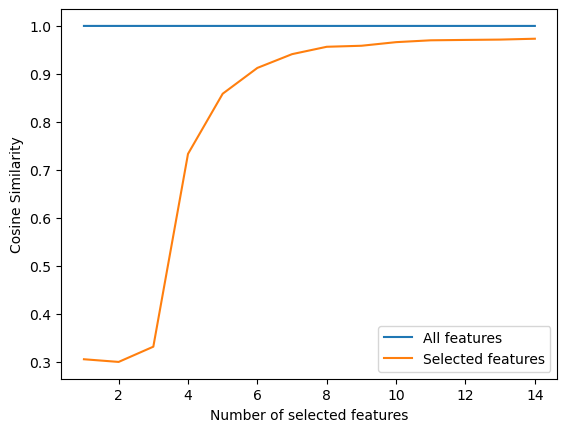

In [18]:
plot_cosine_similarity(activation='activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth', num_features=15)

## Cosine similarity of front layers

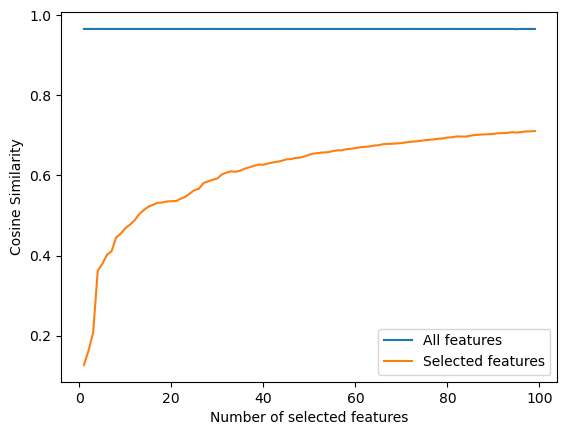

In [19]:

plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth', num_layers=[i for i in range(0,5)], num_features=100)

## Cosine similarity for mid layers

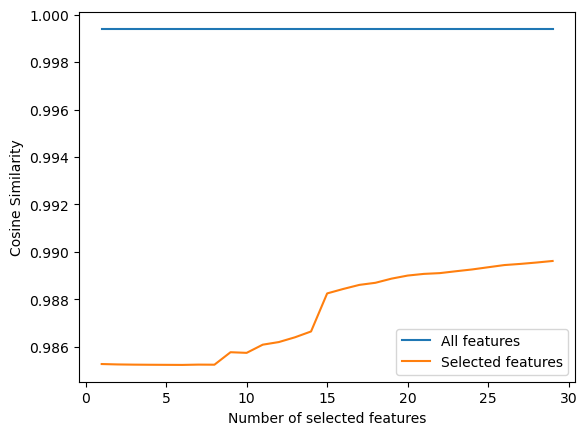

In [20]:

plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth', num_layers=[i for i in range(5,9)], num_features=30)

## less features used for later layer?

Layer 0


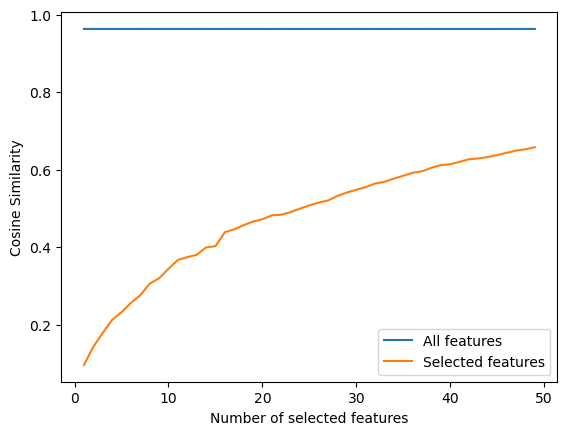

Layer 1


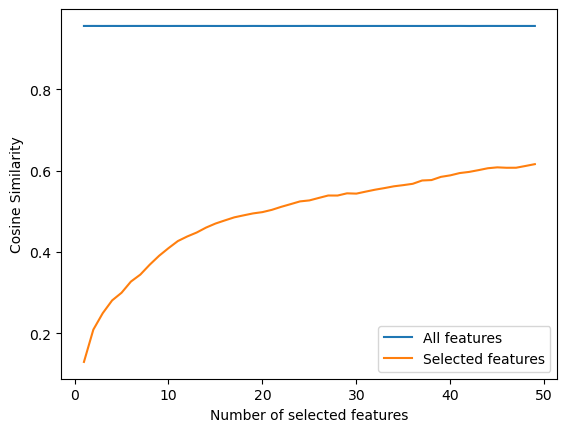

Layer 2


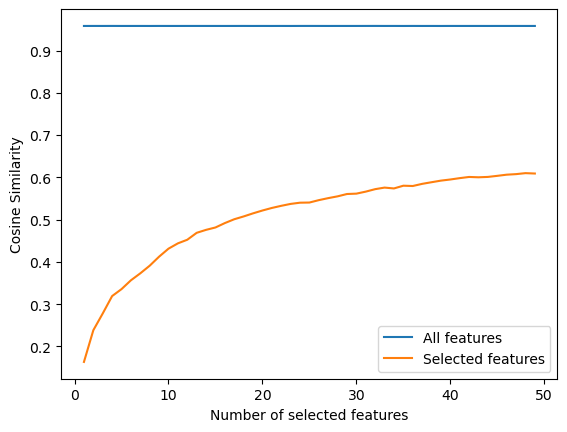

Layer 3


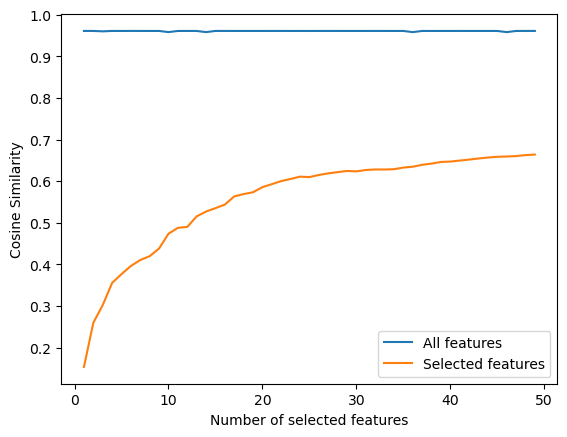

Layer 4


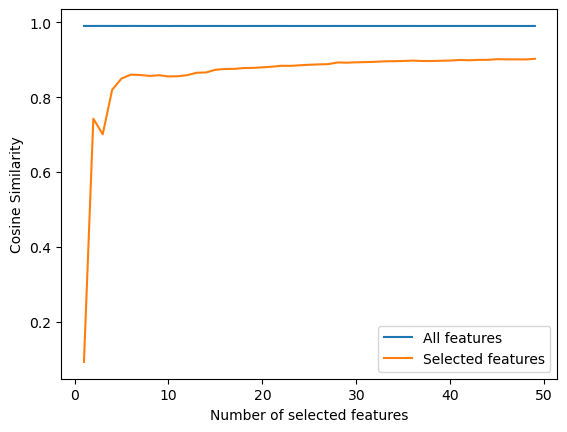

Layer 5


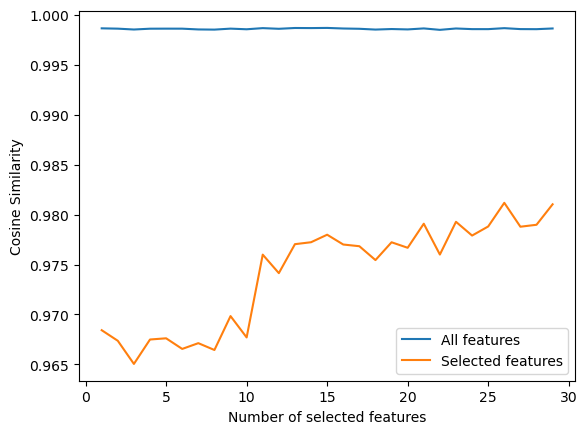

Layer 6


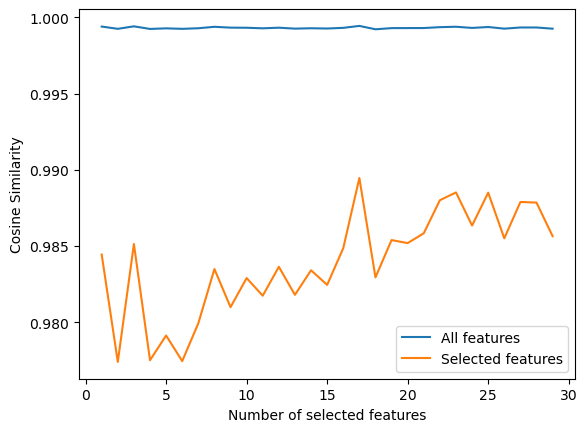

Layer 7


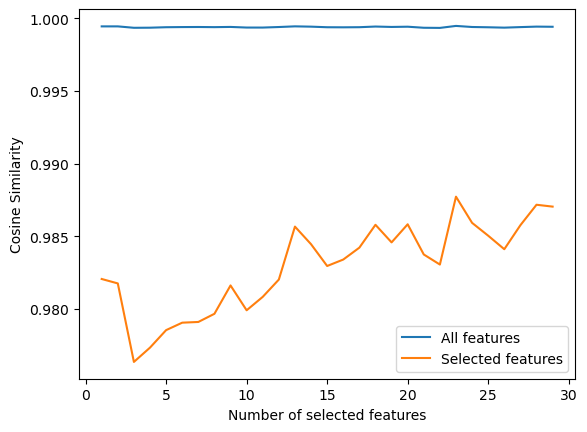

Layer 8


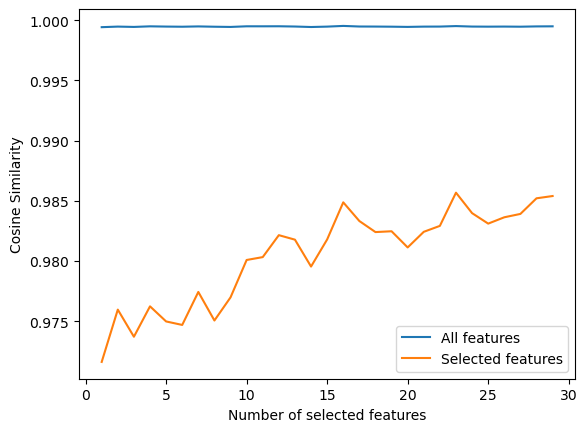

Layer 9


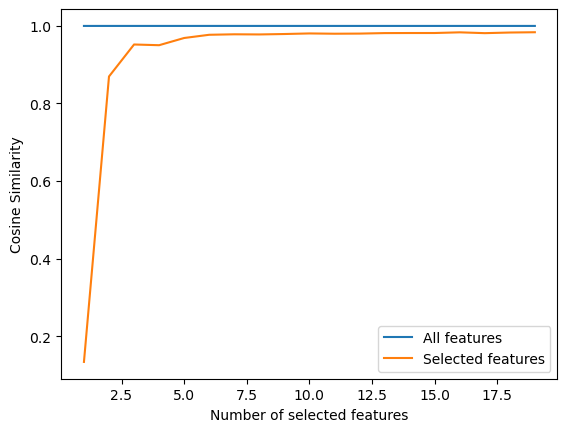

Layer 10


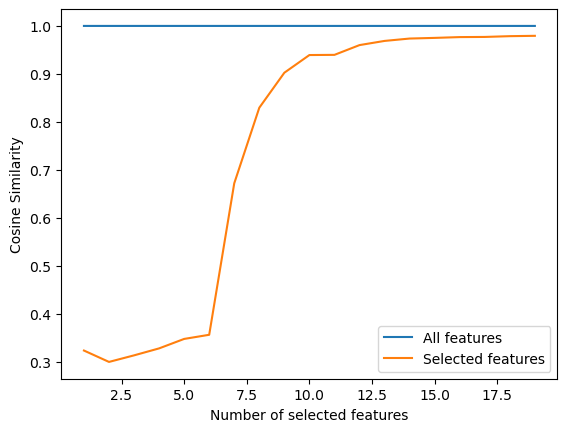

Layer 11


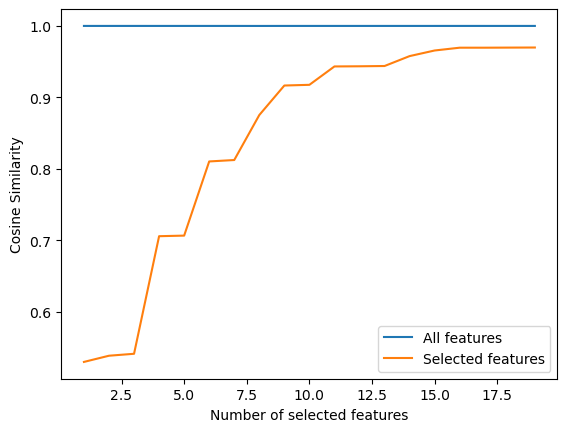

In [21]:
for i in range(12):
    print(f'Layer {i}')
    if i in range(0,5):
        plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth', num_layers=[i], num_features=50)
    elif i in range(5,9):
        plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth', num_layers=[i], num_features=30)
    else:
        plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth', num_layers=[i], num_features=20)

# Cifar x15

In [25]:
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_vit_b/cifar10_activations_{i}.h5',vitmodel='nateraw/vit-base-patch16-224-cifar10',SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',cls=i, ratio=15, num_features=1)

[(11057, 1981)]
Accuracy: 1.0
2000 2000
[(7784, 1998)]
Accuracy: 1.0
2000 2000
[(9407, 1983)]
Accuracy: 1.0
2000 2000
[(9510, 1971)]
Accuracy: 1.0
2000 2000
[(11079, 1988)]
Accuracy: 1.0
2000 2000
[(1930, 1981)]
Accuracy: 1.0
2000 2000
[(336, 1996)]
Accuracy: 1.0
2000 2000
[(11022, 1987)]
Accuracy: 1.0
2000 2000
[(4245, 1981)]
Accuracy: 1.0
2000 2000
[(2933, 1977)]
Accuracy: 1.0
2000 2000


In [26]:
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_vit_b/cifar10_activations_{i}.h5',vitmodel='nateraw/vit-base-patch16-224-cifar10',SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',cls=i, ratio=15, num_features=3)

[(4201, 1995), (11057, 1990), (10133, 1988)]
Accuracy: 0.9985
1997 2000
[(4201, 2000), (7784, 1998), (960, 1991)]
Accuracy: 1.0
2000 2000
[(4201, 2000), (9407, 1991), (10133, 1990)]
Accuracy: 0.998
1996 2000
[(4201, 2000), (10133, 1987), (9510, 1983)]
Accuracy: 0.998
1996 2000
[(4201, 2000), (11079, 1996), (10133, 1987)]
Accuracy: 0.9995
1999 2000
[(4201, 2000), (1930, 1998), (10133, 1995)]
Accuracy: 1.0
2000 2000
[(4201, 2000), (336, 1997), (10133, 1997)]
Accuracy: 0.9995
1999 2000
[(4201, 1999), (11022, 1992), (10133, 1950)]
Accuracy: 0.999
1998 2000
[(4201, 2000), (4245, 1996), (10133, 1989)]
Accuracy: 0.9995
1999 2000
[(4201, 2000), (2933, 1987), (8502, 1975)]
Accuracy: 1.0
2000 2000


In [27]:
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_vit_b/cifar10_activations_{i}.h5',vitmodel='nateraw/vit-base-patch16-224-cifar10',SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',cls=i, ratio=15, num_features=5)

[(4201, 2000), (10133, 1996), (11057, 1993), (10928, 1987), (9375, 1321)]
Accuracy: 1.0
2000 2000
[(4201, 2000), (10133, 2000), (7784, 1998), (960, 1996), (4430, 987)]
Accuracy: 1.0
2000 2000
[(4201, 2000), (10133, 2000), (9407, 1993), (6200, 1981), (4724, 1021)]
Accuracy: 0.999
1998 2000
[(4201, 2000), (10133, 2000), (9510, 1988), (3217, 1790), (1930, 1126)]
Accuracy: 0.934
1868 2000
[(4201, 2000), (10133, 2000), (11079, 1996), (5844, 1988), (2041, 1032)]
Accuracy: 0.9995
1999 2000
[(1930, 2000), (4201, 2000), (10133, 2000), (4642, 1984), (4936, 1184)]
Accuracy: 1.0
2000 2000
[(4201, 2000), (10133, 2000), (336, 1998), (4527, 1997), (4803, 1017)]
Accuracy: 0.9995
1999 2000
[(4201, 1999), (10133, 1998), (11022, 1996), (9602, 1984), (3375, 1969)]
Accuracy: 0.999
1998 2000
[(4201, 2000), (10133, 1999), (4245, 1996), (8150, 1996), (4149, 1969)]
Accuracy: 1.0
2000 2000
[(4201, 2000), (10133, 2000), (2933, 1995), (8502, 1984), (9861, 971)]
Accuracy: 1.0
2000 2000


In [28]:
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_vit_b/cifar10_activations_{i}.h5',vitmodel='nateraw/vit-base-patch16-224-cifar10',SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',cls=i, ratio=15, num_features=10)

[(4201, 2000), (10133, 2000), (11057, 1998), (10928, 1993), (9375, 1564), (11204, 1528), (6550, 1036), (4430, 1027), (6525, 1003), (11072, 1001)]
Accuracy: 0.9995
1999 2000
[(7784, 2000), (4201, 2000), (10133, 2000), (960, 1998), (11204, 1777), (2836, 1006), (4430, 1000), (1121, 996), (3134, 994), (5900, 983)]
Accuracy: 1.0
2000 2000
[(4201, 2000), (10133, 2000), (9407, 1996), (6200, 1990), (11204, 1338), (4724, 1109), (1930, 1044), (4430, 1000), (5778, 996), (7340, 652)]
Accuracy: 0.991
1982 2000
[(4201, 2000), (10133, 2000), (9510, 1992), (3217, 1868), (11204, 1736), (1930, 1433), (4430, 1291), (6554, 1034), (1509, 944), (4460, 797)]
Accuracy: 0.9545
1909 2000
[(4201, 2000), (10133, 2000), (11079, 1996), (5844, 1996), (11204, 1292), (1930, 1184), (2041, 1162), (4430, 1061), (9473, 988), (7115, 953)]
Accuracy: 0.994
1988 2000
[(1930, 2000), (4201, 2000), (10133, 2000), (4642, 1994), (11204, 1859), (4936, 1383), (4430, 1006), (10232, 997), (9510, 869), (11072, 728)]
Accuracy: 0.993
198

## cosine sim

## front layers

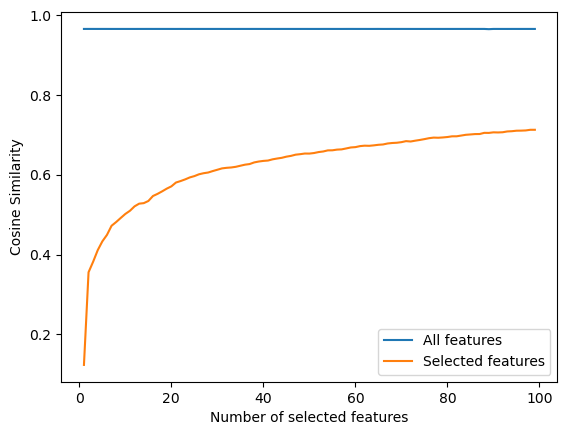

In [29]:
plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',ratio=15, num_layers=[0,1,2,3,4], num_features=100)

## mid layers

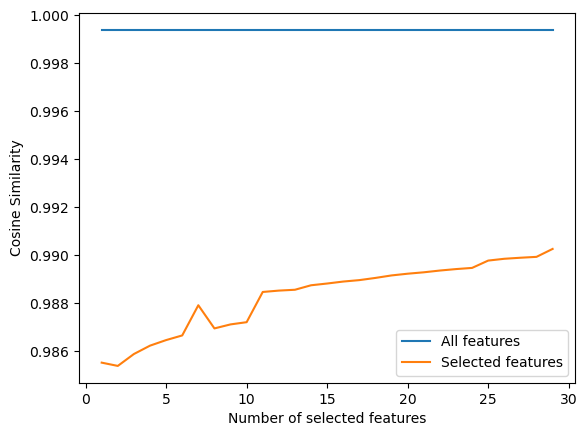

In [30]:
plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',ratio=15, num_layers=[5,6,7,8], num_features=30)

## back layers

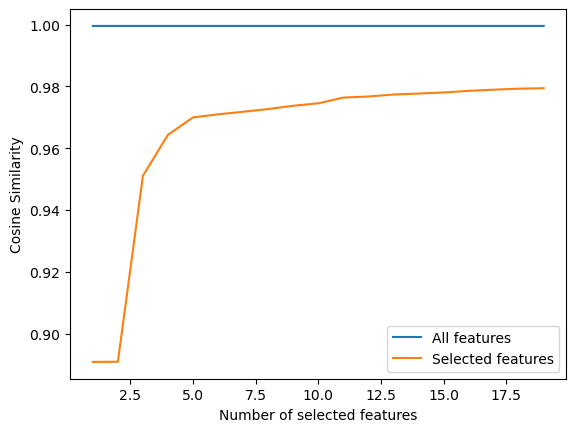

In [31]:
plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',ratio=15, num_layers=[9,10,11], num_features=20)

## by layers

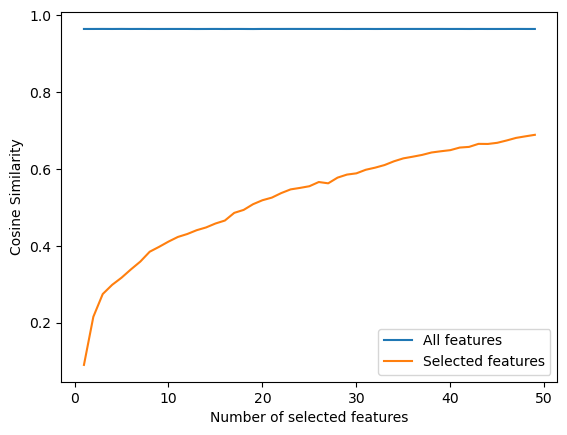

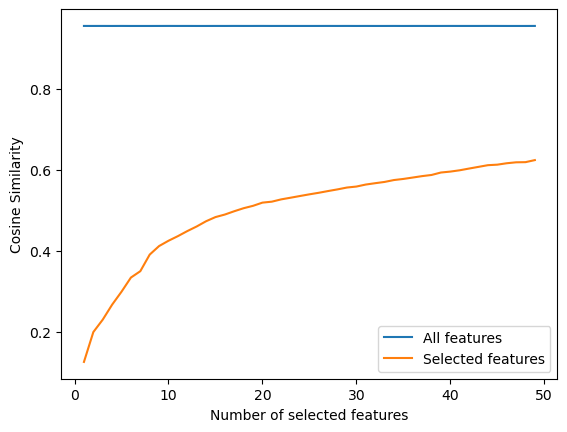

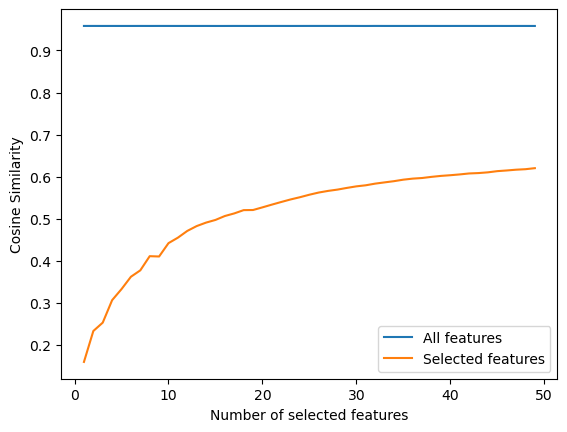

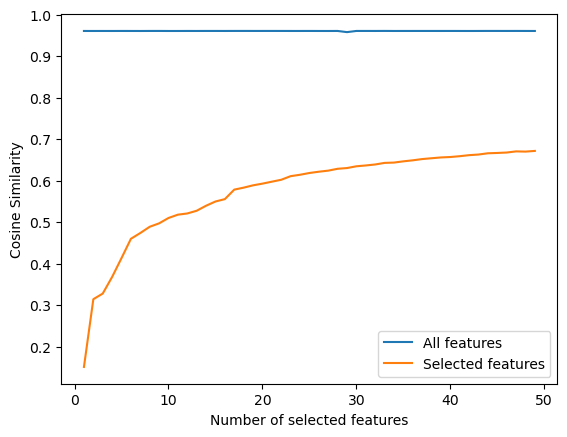

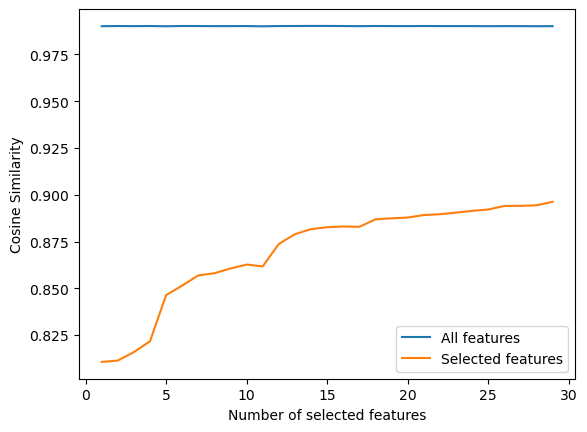

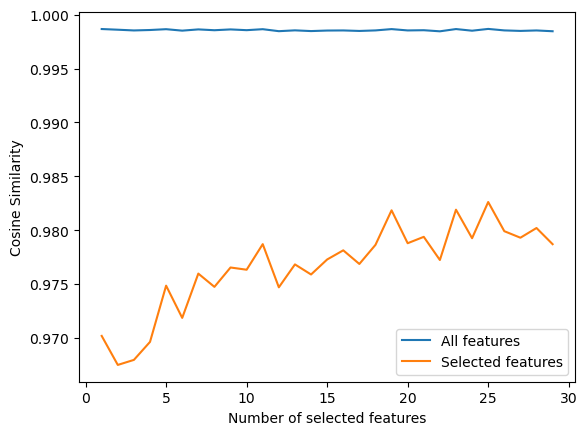

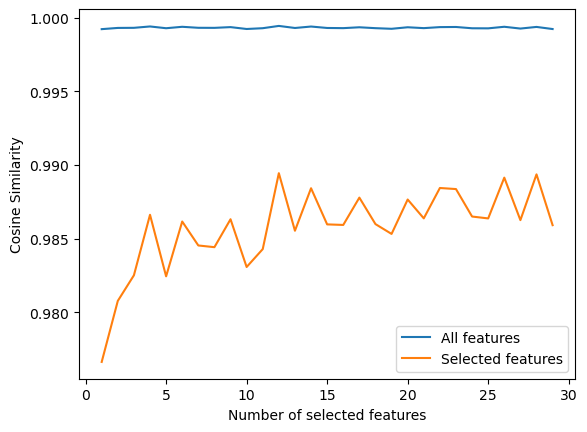

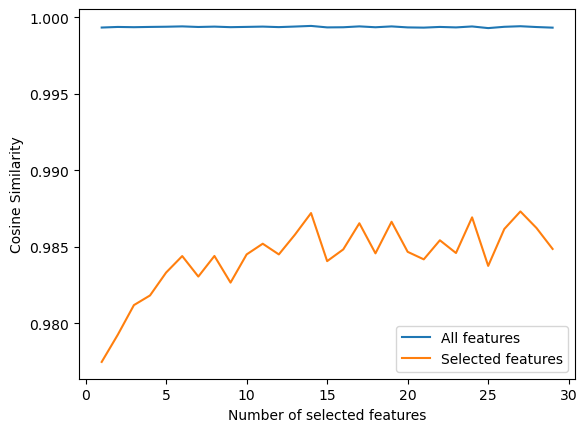

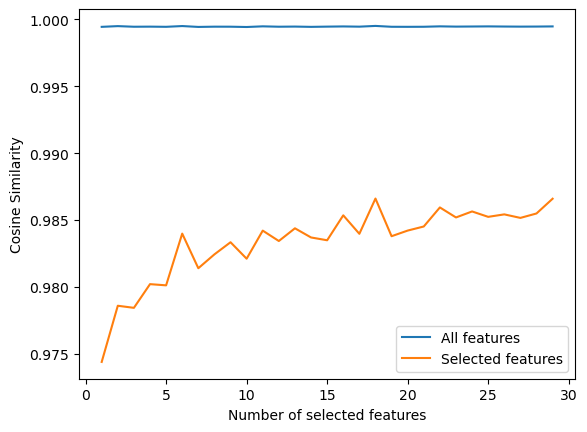

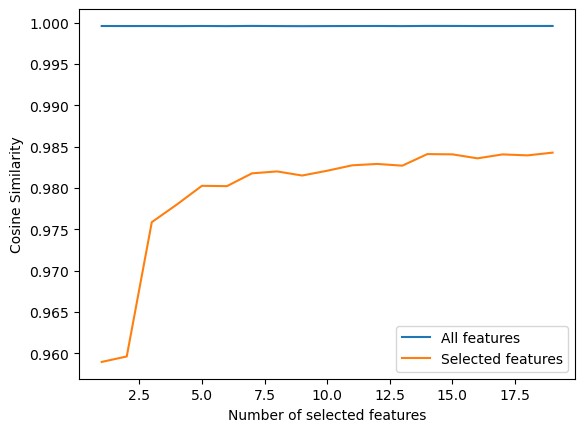

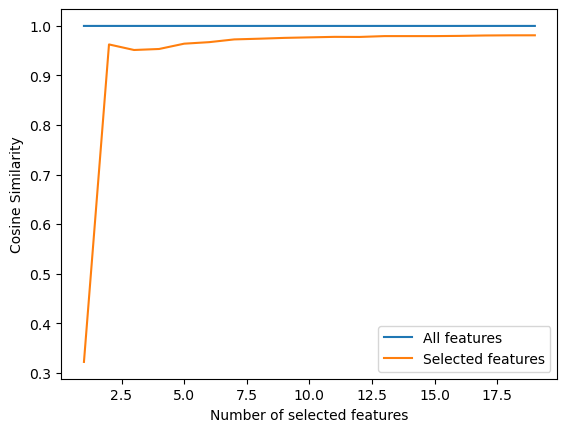

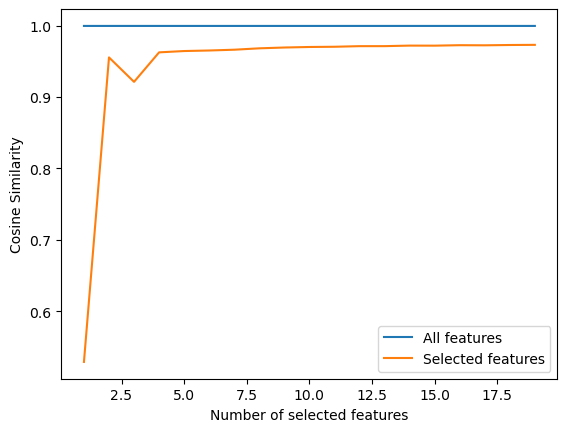

In [32]:
for i in range(0,12):
    if i <4:
        plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',ratio=15, num_layers=[i], num_features=50)
    elif i <9:
        plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',ratio=15, num_layers=[i], num_features=30)
    else:
        plot_cosine_similarity(activation=f'activations_cifar10_vit_b/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',ratio=15, num_layers=[i], num_features=20)

# cat dog x10

In [33]:
for i in range(2):
    use_as_classifier(activation=f'activations_catdog_vit_b/catdog_activations_{i}.h5',vitmodel='akahana/vit-base-cats-vs-dogs', SAEmodel='SAE_models/catdog_finetune/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=1)

[(2075, 7814)]
Accuracy: 1.0
8000 8000
[(1348, 7784)]
Accuracy: 0.994375
7955 8000


In [34]:
for i in range(2):
    use_as_classifier(activation=f'activations_catdog_vit_b/catdog_activations_{i}.h5',vitmodel='akahana/vit-base-cats-vs-dogs', SAEmodel='SAE_models/catdog_finetune/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=3)

[(2075, 7866), (1765, 7738), (6894, 7620)]
Accuracy: 1.0
8000 8000
[(1348, 7839), (1765, 7749), (4985, 7745)]
Accuracy: 0.993625
7949 8000


In [35]:
for i in range(2):
    use_as_classifier(activation=f'activations_catdog_vit_b/catdog_activations_{i}.h5',vitmodel='akahana/vit-base-cats-vs-dogs', SAEmodel='SAE_models/catdog_finetune/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=5)

[(1765, 7983), (2075, 7889), (6894, 7775), (5428, 6967), (6118, 5701)]
Accuracy: 1.0
8000 8000
[(1765, 7951), (1348, 7869), (4985, 7812), (3343, 7677), (109, 4828)]
Accuracy: 0.993625
7949 8000


In [37]:
for i in range(2):
    use_as_classifier(activation=f'activations_catdog_vit_b/catdog_activations_{i}.h5',vitmodel='akahana/vit-base-cats-vs-dogs', SAEmodel='SAE_models/catdog_finetune/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=10)

[(1765, 8000), (2075, 7908), (6894, 7840), (4031, 7504), (5428, 7326), (6118, 6784), (1762, 6726), (69, 6519), (6930, 3911), (1958, 3862)]
Accuracy: 1.0
8000 8000
[(1765, 7998), (1348, 7894), (4985, 7869), (3343, 7813), (4031, 6805), (109, 6156), (710, 4750), (1947, 3987), (768, 3942), (5765, 3833)]
Accuracy: 0.99475
7958 8000


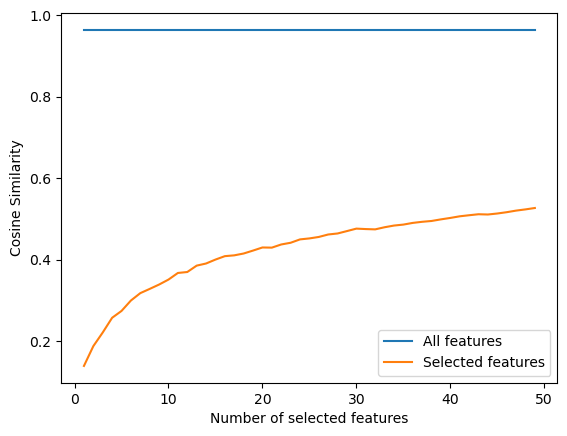

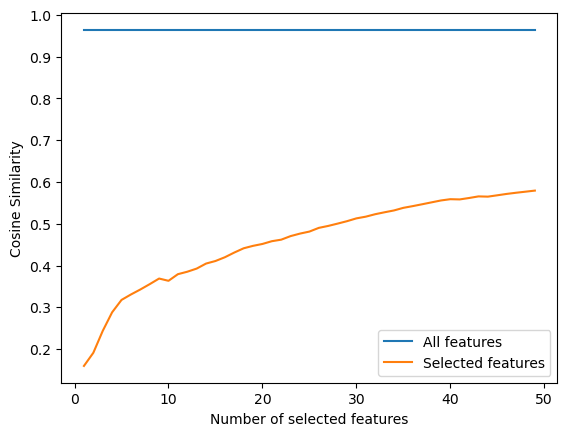

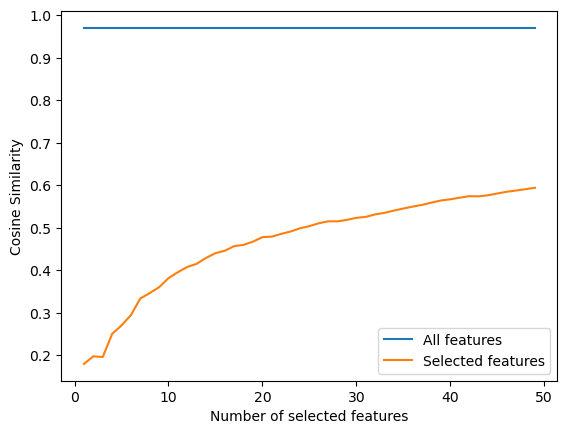

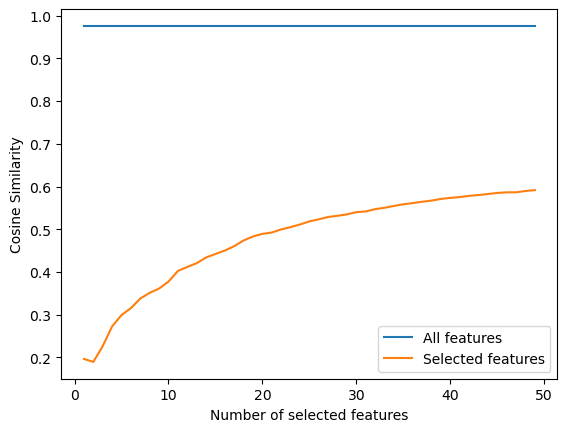

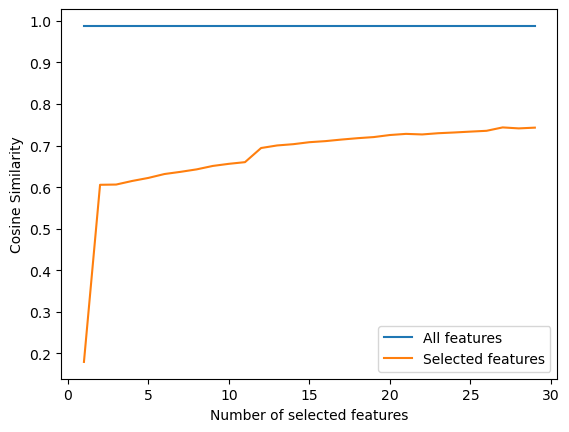

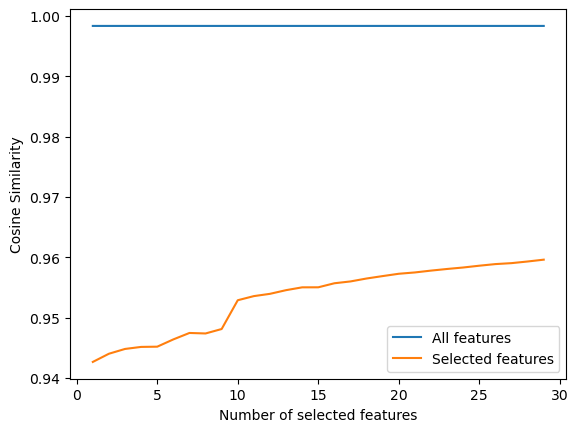

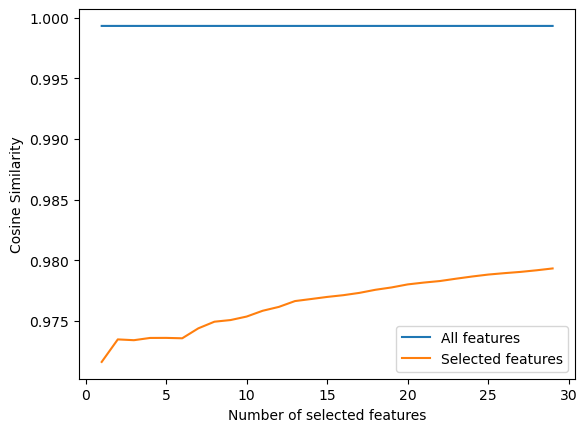

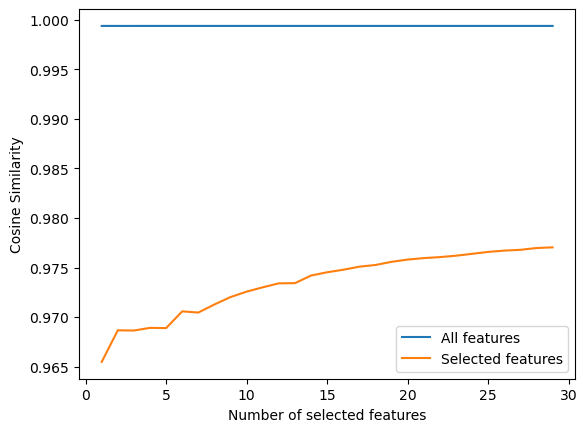

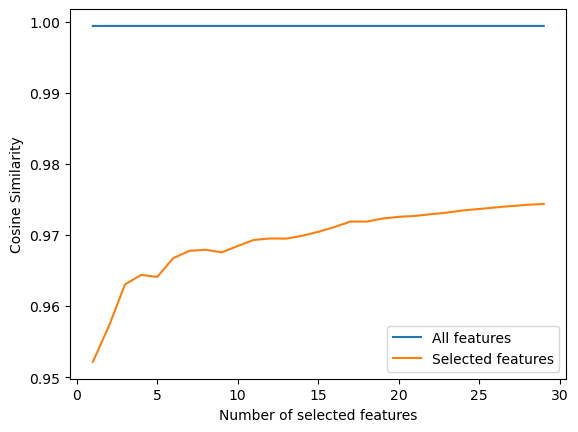

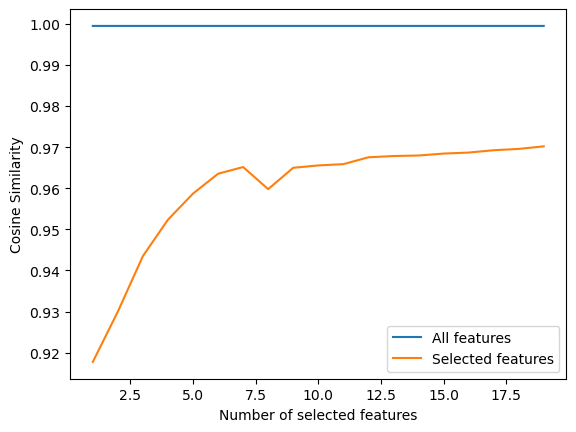

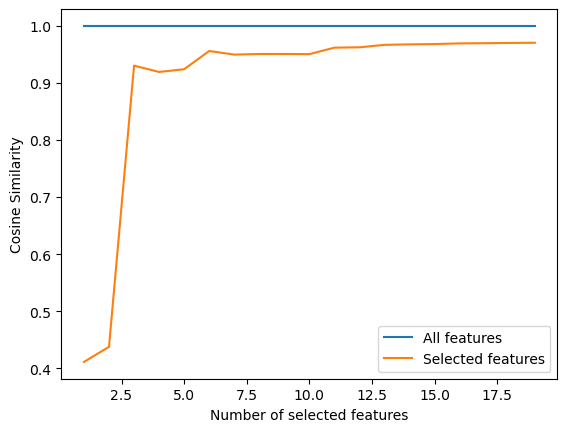

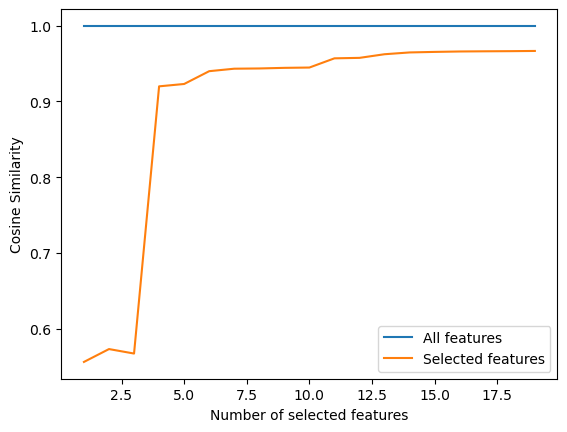

In [36]:
for i in range(0,12):
    if i <4:
        plot_cosine_similarity(activation='activations_catdog_vit_b/catdog_activations_0.h5', SAEmodel='SAE_models/catdog_finetune/SAE_ratio10_epoch100_lr0.0001.pth',ratio=10, num_layers=[i], num_features=50)
    elif i <9:
        plot_cosine_similarity(activation='activations_catdog_vit_b/catdog_activations_0.h5', SAEmodel='SAE_models/catdog_finetune/SAE_ratio10_epoch100_lr0.0001.pth',ratio=10, num_layers=[i], num_features=30)
    else:
        plot_cosine_similarity(activation='activations_catdog_vit_b/catdog_activations_0.h5', SAEmodel='SAE_models/catdog_finetune/SAE_ratio10_epoch100_lr0.0001.pth',ratio=10, num_layers=[i], num_features=20)

# catdog dino

In [5]:
for i in range(2):
    use_as_classifier(activation=f'activations_catdog_dino_vitb16/catdog_activations_{i}.h5',vitmodel='facebook/dino-vitb16', SAEmodel='SAE_models/catdog_dino/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=1, finetuned_model='DINO_classifiers_finetued/catdog_dino-vitb16_classifier.pth')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(6099, 8000)]
Accuracy: 0.0
0 8000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(6099, 8000)]
Accuracy: 1.0
8000 8000


In [6]:
for i in range(2):
    use_as_classifier(activation=f'activations_catdog_dino_vitb16/catdog_activations_{i}.h5',vitmodel='facebook/dino-vitb16', SAEmodel='SAE_models/catdog_dino/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=10, finetuned_model='catdog_dino-vitb16_classifier.pth')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(6099, 8000), (3391, 8000), (6468, 8000), (953, 6528), (2830, 6287), (6028, 5413), (4480, 4007), (545, 4000), (5655, 3645), (2289, 3418)]
Accuracy: 0.13925
1114 8000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(6099, 8000), (3391, 8000), (6468, 8000), (6028, 5710), (953, 5099), (4480, 4006), (545, 4000), (2939, 2649), (790, 2514), (2580, 1864)]
Accuracy: 1.0
8000 8000


In [7]:
for i in range(2):
    use_as_classifier(activation=f'activations_catdog_dino_vitb16/catdog_activations_{i}.h5',vitmodel='facebook/dino-vitb16', SAEmodel='SAE_models/catdog_dino/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=20, finetuned_model='catdog_dino-vitb16_classifier.pth')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(6099, 8000), (3391, 8000), (6468, 8000), (953, 7510), (6028, 6869), (2830, 6800), (5655, 5782), (2289, 5364), (7403, 4589), (4480, 4143), (5398, 4068), (545, 4000), (1804, 3587), (2939, 3497), (6141, 2813), (3615, 2809), (1081, 2177), (790, 2118), (5907, 1936), (1923, 1913)]
Accuracy: 0.220375
1763 8000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(6099, 8000), (3391, 8000), (6468, 8000), (6028, 7279), (953, 7060), (2939, 4646), (4480, 4074), (545, 4000), (7127, 3640), (790, 3047), (6141, 3003), (7403, 2709), (5663, 2671), (6789, 2523), (2580, 2482), (5655, 2442), (5549, 2177), (4442, 2065), (1804, 1991), (5398, 1946)]
Accuracy: 1.0
8000 8000


In [9]:
for i in range(2):
    use_as_classifier(activation=f'activations_catdog_dino_vitb16/catdog_activations_{i}.h5',vitmodel='facebook/dino-vitb16', SAEmodel='SAE_models/catdog_dino/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=50, finetuned_model='catdog_dino-vitb16_classifier.pth')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(6099, 8000), (3391, 8000), (6468, 8000), (953, 7928), (6028, 7873), (5655, 7359), (2830, 7251), (1804, 7157), (7403, 7060), (2289, 7004), (2939, 5645), (5398, 5391), (4735, 5356), (4480, 5073), (5907, 4276), (5949, 4125), (545, 4009), (6141, 3886), (7127, 3879), (1923, 3771), (2095, 3713), (1081, 3536), (2448, 3480), (3615, 3421), (790, 3379), (66, 3175), (5181, 3131), (5933, 3092), (4173, 2773), (7416, 2658), (5247, 2471), (4442, 2456), (2297, 2455), (2677, 2410), (2580, 2393), (3374, 2308), (1183, 2226), (75, 2166), (7354, 1983), (647, 1882), (7182, 1867), (1542, 1833), (7370, 1828), (7463, 1820), (70, 1802), (2444, 1744), (6158, 1741), (3128, 1722), (4576, 1714), (4813, 1703)]
Accuracy: 0.1865
1492 8000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(6099, 8000), (3391, 8000), (6468, 8000), (6028, 7956), (953, 7838), (1804, 6685), (2939, 6552), (7403, 5919), (5655, 5704), (7127, 5629), (6789, 4466), (4480, 4426), (4442, 4382), (545, 4015), (5663, 4001), (6141, 3956), (790, 3945), (4735, 3791), (1420, 3741), (2095, 3681), (7416, 3405), (2580, 3339), (4741, 3009), (2444, 2933), (5398, 2866), (5549, 2673), (2057, 2633), (5422, 2447), (5907, 2324), (1923, 2320), (2448, 2287), (5936, 2267), (4813, 2229), (5181, 2114), (4348, 2112), (3260, 1973), (7296, 1865), (1081, 1721), (5698, 1716), (6748, 1700), (1811, 1664), (6158, 1588), (5949, 1551), (7370, 1549), (1247, 1549), (5933, 1489), (2297, 1481), (3124, 1414), (4173, 1392), (6183, 1366)]
Accuracy: 0.916
7328 8000


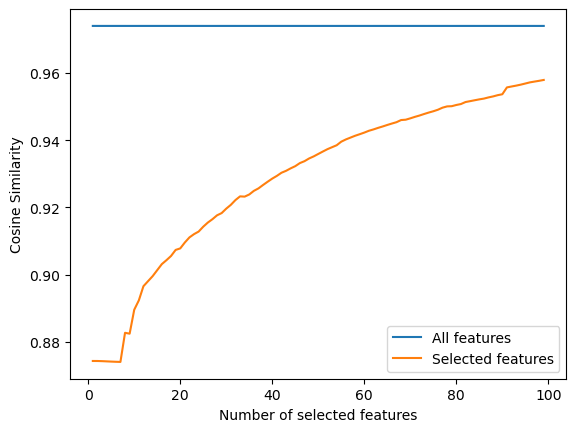

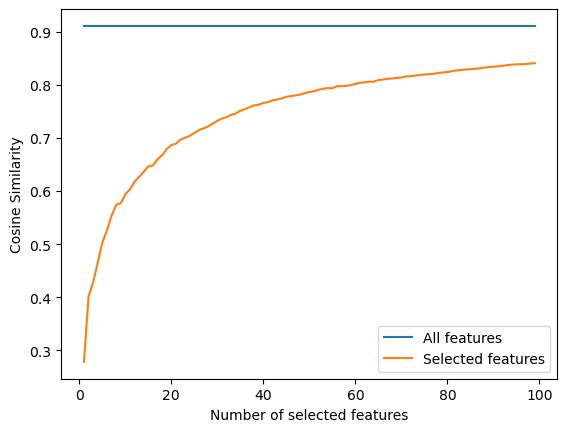

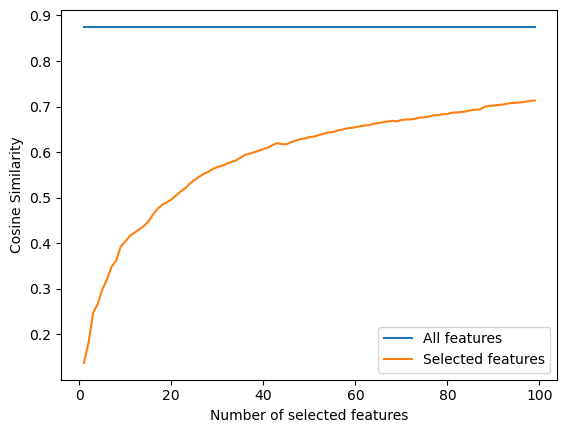

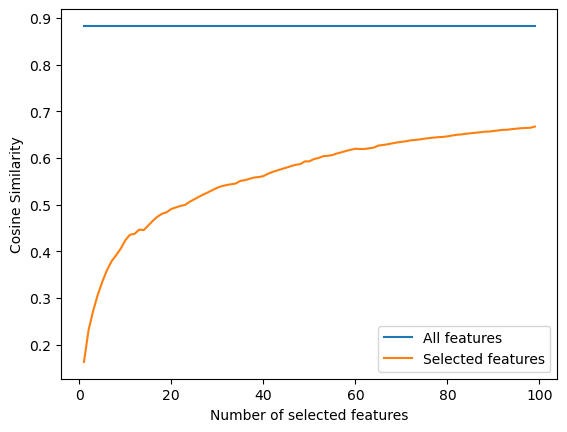

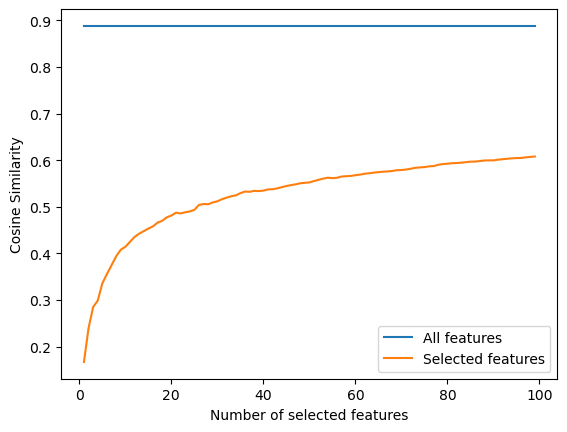

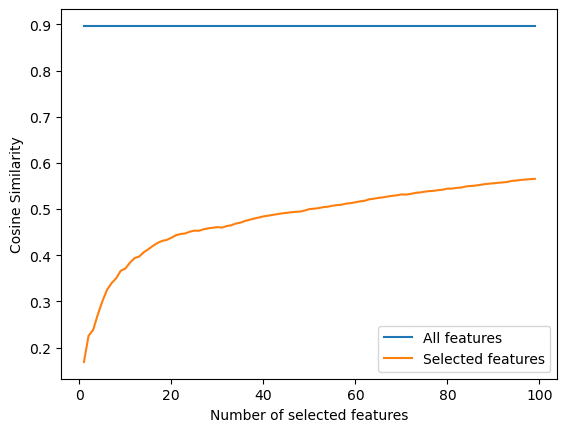

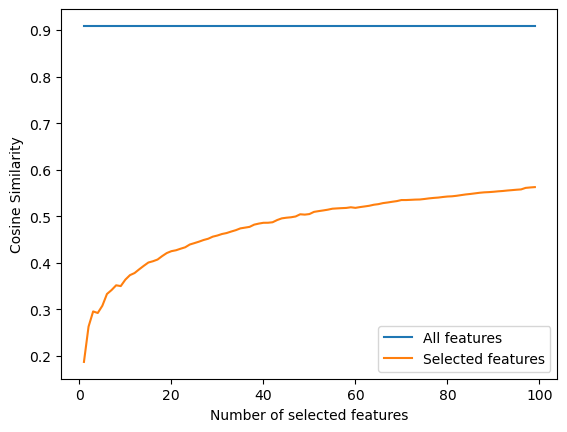

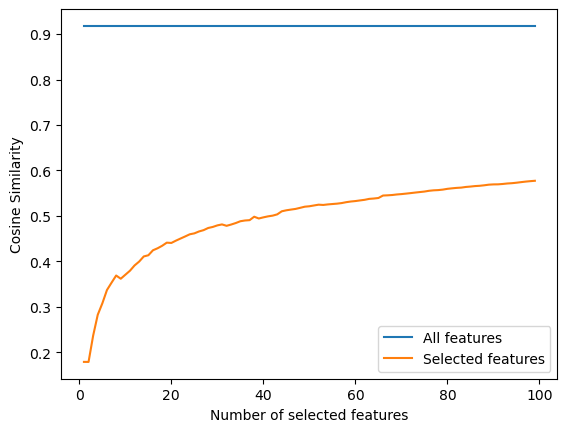

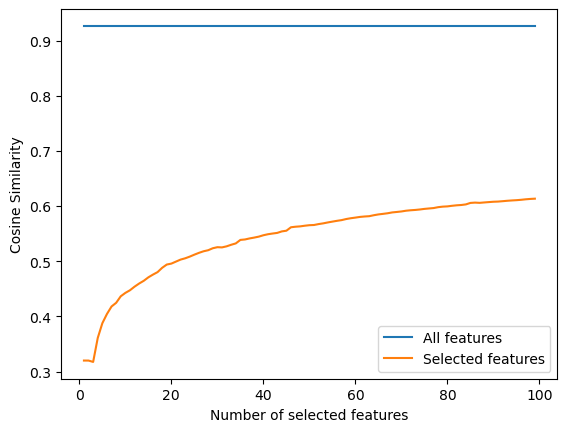

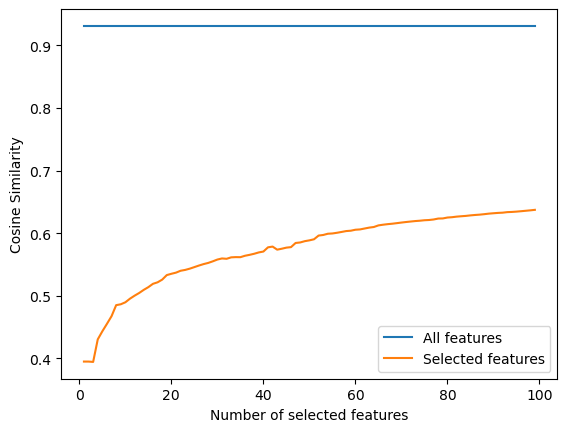

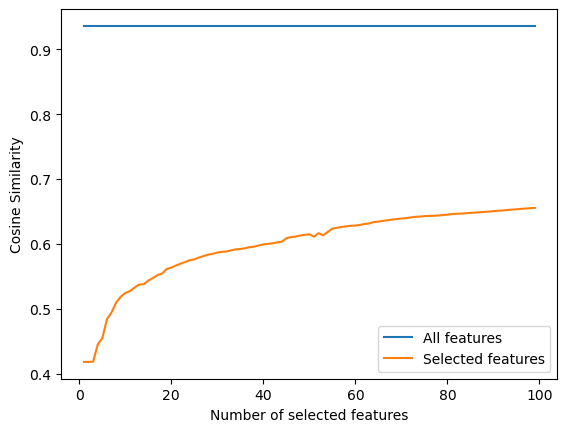

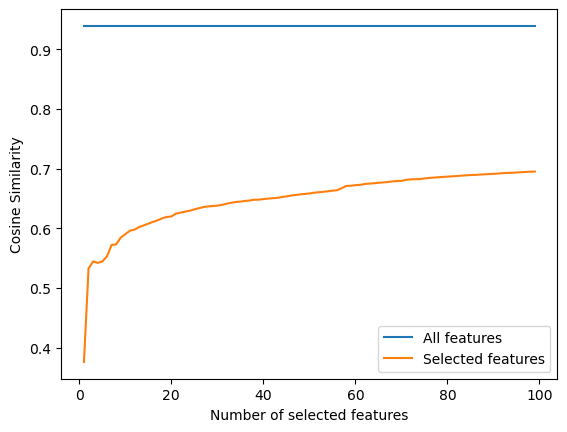

In [13]:
for i in range(0,12):
        plot_cosine_similarity(activation='activations_catdog_dino_vitb16/catdog_activations_0.h5', SAEmodel='SAE_models/catdog_dino/SAE_ratio10_epoch100_lr0.0001.pth',ratio=10, num_layers=[i], num_features=100)

# cifar dino

In [14]:
#full test accuracy with trained classifier 0.9496999979019165
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_dino_vitb16/cifar10_activations_{i}.h5',vitmodel='facebook/dino-vitb16', SAEmodel='SAE_models/cifar10_dino/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=1, finetuned_model='DINO_classifiers_finetued/cifar_dino-vitb16_classifier.pth') 

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 1.0
2000 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000)]
Accuracy: 0.0
0 2000


In [21]:
#full test accuracy with trained classifier 0.9496999979019165
for i in range(10):
    use_as_classifier(activation=f'activations_cifar10_dino_vitb16/cifar10_activations_{i}.h5',vitmodel='facebook/dino-vitb16', SAEmodel='SAE_models/cifar10_dino/SAE_ratio10_epoch100_lr0.0001.pth',cls=i, ratio=10, num_features=30, finetuned_model='cifar_dino-vitb16_classifier.pth')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1977), (4025, 1940), (7218, 1932), (3443, 1731), (1072, 1320), (7050, 1183), (6575, 1061), (2588, 1059), (2270, 1052), (4224, 1003), (7086, 1000), (3487, 745), (880, 642), (2305, 637), (5491, 537), (6214, 461), (1982, 451), (1815, 428), (718, 399), (2296, 389), (3122, 384), (844, 380), (4625, 376), (3362, 357), (2529, 342), (5681, 342), (3493, 329), (4910, 329)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1870), (6832, 1823), (4025, 1758), (3443, 1703), (7218, 1497), (5806, 1441), (1072, 1421), (1673, 1396), (1514, 1278), (2146, 1200), (2984, 1194), (6575, 1018), (4224, 1002), (7086, 1000), (2588, 856), (6121, 850), (6214, 778), (3496, 697), (6245, 690), (3444, 681), (1707, 670), (401, 669), (2126, 647), (3121, 631), (3638, 625), (5834, 598), (2305, 596), (6039, 566)]
Accuracy: 0.003
6 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1881), (4025, 1815), (3443, 1649), (1072, 1475), (7218, 1284), (4224, 1012), (6575, 1010), (7086, 1000), (3362, 937), (4575, 922), (6121, 901), (700, 866), (5834, 822), (375, 635), (3654, 600), (2588, 598), (401, 577), (2050, 481), (3068, 473), (2305, 439), (2270, 439), (5865, 437), (1263, 430), (1707, 424), (7050, 400), (5119, 399), (175, 388), (3194, 369)]
Accuracy: 0.2305
461 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1962), (4025, 1906), (3068, 1462), (3443, 1438), (1072, 1382), (7218, 1377), (6575, 1008), (4224, 1002), (7086, 1000), (1707, 873), (1808, 816), (5834, 782), (2588, 631), (401, 564), (5947, 557), (2848, 520), (93, 508), (3094, 508), (2305, 503), (1379, 498), (487, 468), (3315, 465), (3773, 440), (7016, 412), (4376, 410), (3194, 387), (3135, 374), (2972, 366)]
Accuracy: 0.0245
49 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1885), (4025, 1741), (4575, 1542), (3362, 1521), (6121, 1493), (1072, 1489), (3443, 1435), (2972, 1061), (4224, 1007), (6575, 1001), (7086, 1000), (3773, 823), (820, 803), (7218, 756), (3068, 703), (5119, 660), (401, 614), (2050, 570), (391, 564), (3015, 546), (5865, 542), (4909, 524), (1263, 501), (3194, 441), (1707, 439), (4941, 418), (5900, 417), (687, 415)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1847), (3068, 1784), (4025, 1684), (3443, 1647), (1072, 1276), (7218, 1202), (5834, 1062), (4224, 1003), (6575, 1002), (7086, 1000), (1808, 841), (401, 784), (3773, 673), (7318, 635), (1707, 620), (1263, 604), (6121, 586), (3362, 559), (2972, 530), (3345, 503), (7465, 496), (2588, 446), (3015, 441), (5313, 438), (5212, 433), (4575, 399), (3315, 384), (6429, 377)]
Accuracy: 0.0525
105 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1997), (4025, 1994), (1072, 1346), (3443, 1226), (4902, 1035), (6575, 1022), (4224, 1001), (7086, 1000), (3068, 869), (7218, 845), (4575, 800), (1707, 755), (6121, 724), (6923, 662), (2848, 631), (6369, 622), (5331, 620), (5865, 616), (5834, 612), (2050, 605), (5119, 603), (3773, 577), (3194, 573), (6345, 569), (2654, 559), (3205, 488), (2588, 486), (5636, 462)]
Accuracy: 0.6945
1389 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1776), (3443, 1698), (4025, 1563), (3362, 1503), (3773, 1449), (2972, 1416), (1072, 1402), (7218, 1312), (6121, 1302), (391, 1065), (2076, 1040), (7050, 1012), (3068, 1011), (4224, 1003), (6575, 1000), (7086, 1000), (4909, 957), (4985, 921), (401, 797), (3015, 779), (4575, 738), (7318, 683), (2588, 668), (2305, 557), (820, 527), (5834, 502), (5066, 474), (1263, 462)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1924), (4025, 1880), (7218, 1863), (3443, 1585), (7050, 1422), (1759, 1413), (1072, 1329), (6575, 1013), (4224, 1002), (7086, 1000), (880, 962), (7486, 796), (2270, 750), (3412, 664), (4910, 609), (3122, 599), (405, 578), (2588, 569), (718, 548), (7524, 521), (6121, 518), (1002, 461), (2305, 456), (5834, 427), (3739, 419), (675, 419), (1707, 418), (6214, 361)]
Accuracy: 0.0
0 2000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(3124, 2000), (3989, 2000), (5697, 1998), (4025, 1968), (7218, 1716), (3443, 1572), (1072, 1460), (1514, 1397), (7050, 1263), (1673, 1016), (6832, 1010), (4224, 1005), (6575, 1005), (7086, 1000), (2588, 990), (5806, 894), (6121, 894), (3246, 880), (6245, 879), (6214, 772), (2164, 731), (2270, 690), (1252, 679), (2591, 663), (1707, 622), (718, 611), (2305, 601), (1027, 577), (2131, 520), (2848, 487)]
Accuracy: 0.0
0 2000


Layer 0


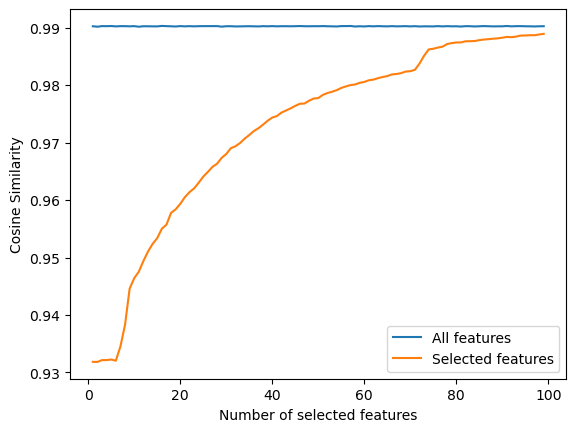

Layer 1


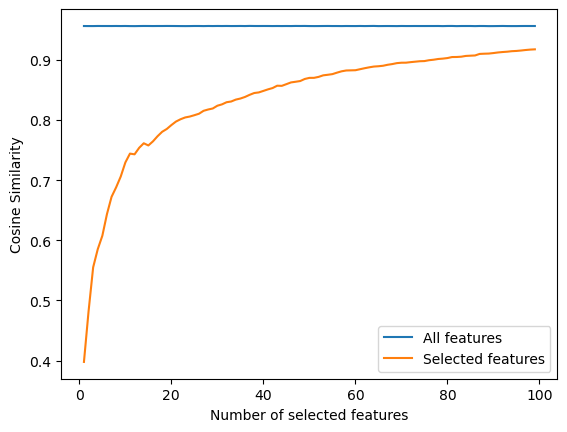

Layer 2


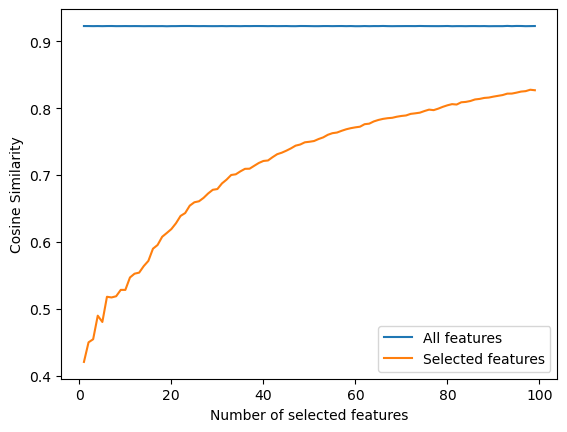

Layer 3


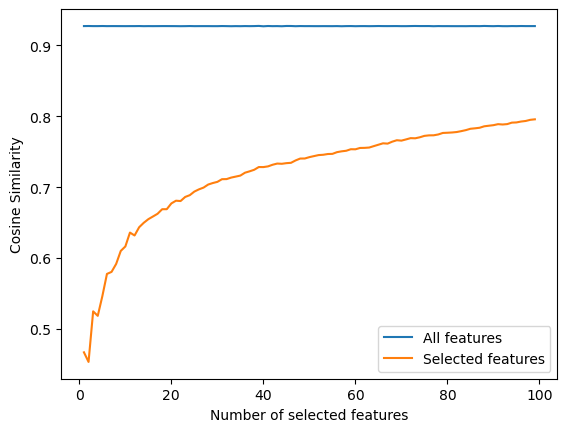

Layer 4


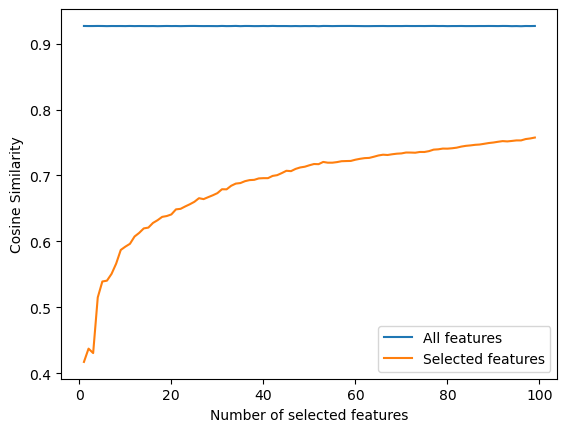

Layer 5


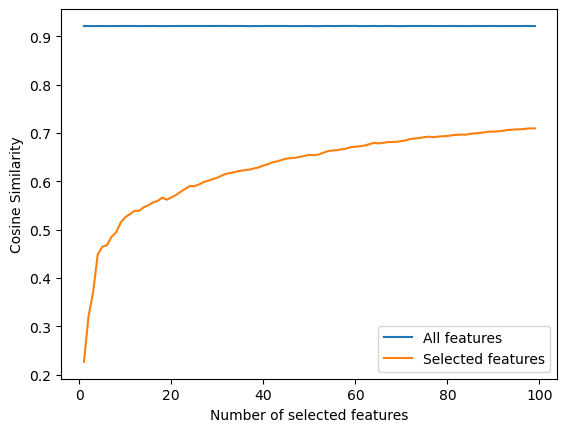

Layer 6


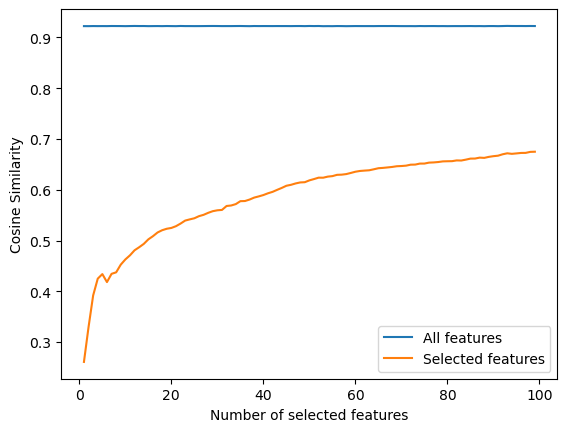

Layer 7


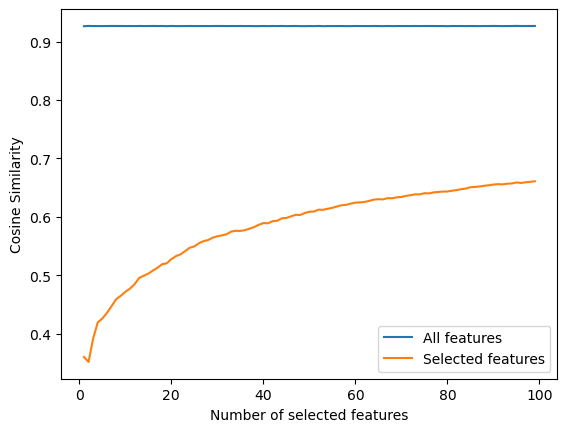

Layer 8


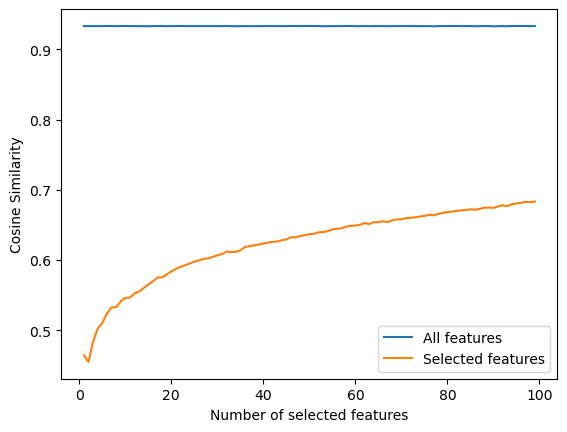

Layer 9


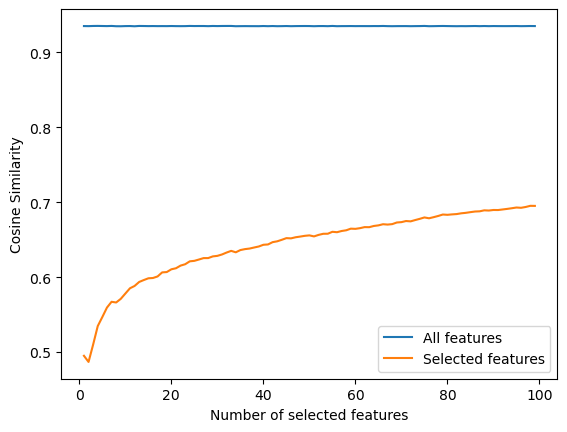

Layer 10


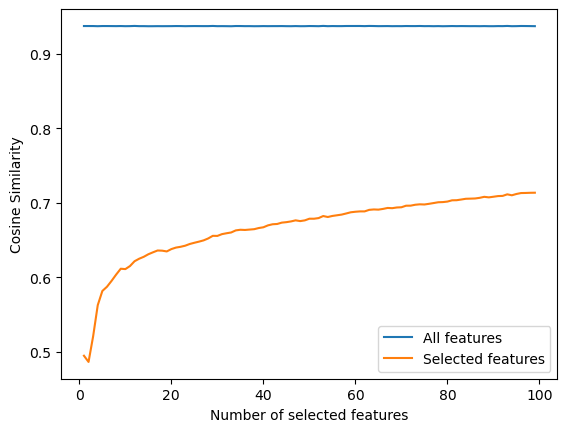

Layer 11


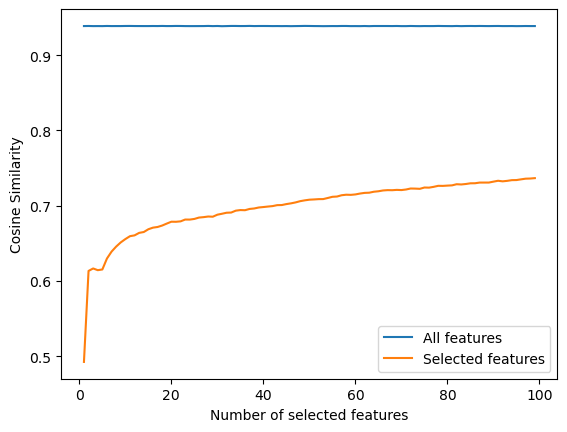

In [20]:
for i in range(0,12):
    print(f'Layer {i}')
    plot_cosine_similarity(activation=f'activations_cifar10_dino_vitb16/cifar10_activations_0.h5', SAEmodel='SAE_models/cifar10_dino/SAE_ratio10_epoch100_lr0.0001.pth',ratio=10, num_layers=[i], num_features=100)